# Analyzing videos of particles sedimenting under gravity in 350cSt silicone oil

First we do the approprate imports, the key packages are trackpy and the cloned directory of the [Shell Model](https://nbviewer.jupyter.org/github/johnemmanuelbond/ShellModel/blob/master/Overview.ipynb) from my github.

In [1]:
import os
import timeit
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

gitPath = os.getcwd() + "\\ShellModel"
workPath = os.getcwd()

if(os.path.isdir(gitPath)!=True):
    !git clone https://github.com/johnemmanuelbond/ShellModel

os.chdir(gitPath)
from supports import *
from Collections import *
from Analyzer import *
from ParticleArray import *
from ArrayMovie import *
os.chdir(workPath)

import trackpy as tp
import pims

Next we add in two videos taken of 0.06" diameter steel ball bearings sedimenting through 350cSt silicone oil.

In [62]:
from IPython.display import YouTubeVideo

YouTubeVideo('dokyLnLmd1U',width=300,height=300)

In [63]:
YouTubeVideo('u_Mj0_9ZI2Q',width=300,height=300)

In [64]:
#location of videos
path = "C:\\Users\\jbond13\\LiquidCrystals\\Data\\"

#getting frames for analysis,
v_26 = pims.ImageSequence(path+"4.27edits\\Trial26_contrast\\*.tif")
v_28 = pims.ImageSequence(path+"4.27edits\\Trial28_contrast\\*.tif")

We use [trackpy](http://soft-matter.github.io/trackpy/v0.4.2/index.html) to track the spheres as they sediment. I've written a method to take in one of the pims frame arrays and locate then link the particles together. The method only keeps the particles whose trajectories cover a long enough distance. This eliminates the sharpie mark and other artifiacts in the video that are, in fact, not sedimenting spheres.

In [3]:
def getTrajectories(v, label = "video", app = 1):
    
    #locating and annotating
    f = tp.locate(v[140],15,minmass=1000,maxsize=8,invert=True, topn=10)
    fig, ax = plt.subplots(figsize=(13, 13))
    tp.annotate(f,v[140], plot_style=dict(markersize=10))
    ax.set_title("Annotated: " + label,fontsize=20)
    fig.savefig(path+"results\\Annotated; " + label + ".png")

    # Optionally, label the axes.
    ax.set(xlabel='mass', ylabel='count');
    
    # linking trajectories
    tp.quiet()
    f=tp.batch(v[:],15,minmass=700,maxsize=6,invert=True, topn = 6)
    t = tp.link_df(f, 80, memory=10)
    
    #filter out transient particles
    t1 = tp.filter_stubs(t, 10)
    # Compare the number of particles in the unfiltered and filtered data.
    print("Filtering stubs...")
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    
    #selecting only the trajectories that cover significant distance
    n = np.max(t1['particle'])
    ptcls = []
    for i in np.arange(n+1):
        xs = t1[t1['particle']==i]['x']
        ys = t1[t1['particle']==i]['y']
        if (xs.size!=0) & (ys.size!=0):
            if (np.sqrt((xs.iat[xs.size-1]-xs.iat[0])**2+(ys.iat[ys.size-1]-ys.iat[0])**2) > 500):
                ptcls.append(i)

    traj1 = t1[t1['particle']==ptcls[0]]
    traj2 = t1[t1['particle']==ptcls[1]]
    traj3 = t1[t1['particle']==ptcls[2]]

    t2 = pd.concat([traj1,traj2,traj3], axis=0)
    
    #centering
    minx = np.min(np.array(t2['x']))
    miny = np.min(np.array(t2['y']))
    
    t2['x'] = t2['x'] - minx
    t2['y'] = t2['y'] - miny
    
    #fixing units
    t2['x'] = t2['x']*app
    t2['y'] = -(t2['y']*app)
    
    #plotting and showing
    fig, ax = plt.subplots(figsize=(13, 13))
    ax = tp.plot_traj(t2)
    ax.invert_yaxis()
    ax.set_title("Trajectories: " + label)
    fig.savefig(path+"results\\Trajectories; " + label +".png")
    
    print("Finished Trajectories")
    print("------------------------------------------------")
    
    return t2

The method above accounts for the units difference between the experiment (pixels) and the model (radii). In all the models we set a = 0.762, which is the radius of the ball in mm. We measured several diameters of the balls from the video and used that to get a conversion factor from pixels to radii. Sorry, but the trajectory graphs are upside down (whoops), it's not important enough to fix at this stage and it would be a pain to go through all the mpl documentation to uninvert an axis.

In [7]:
#Measuring pixels and Radii
d_in_simulation = 2*0.762 #0.03 inches in mm

#Trial 26
d_in_pixels_26 = np.mean(np.array([13.333,14.016,11.338,14.701,13.333,15.670]))
app_26 = d_in_simulation/d_in_pixels_26

#Trial 28
d_in_pixels_28 = np.mean(np.array([13.271,16.752,14.250,15.750,15.252,16.095]))
app_28 = d_in_simulation/d_in_pixels_28

## Getting and plotting experimental trajectories

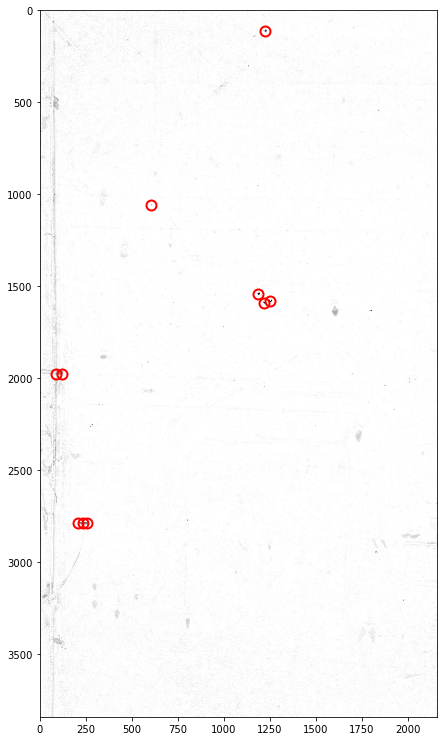

Filtering stubs...
Before: 27
After: 10


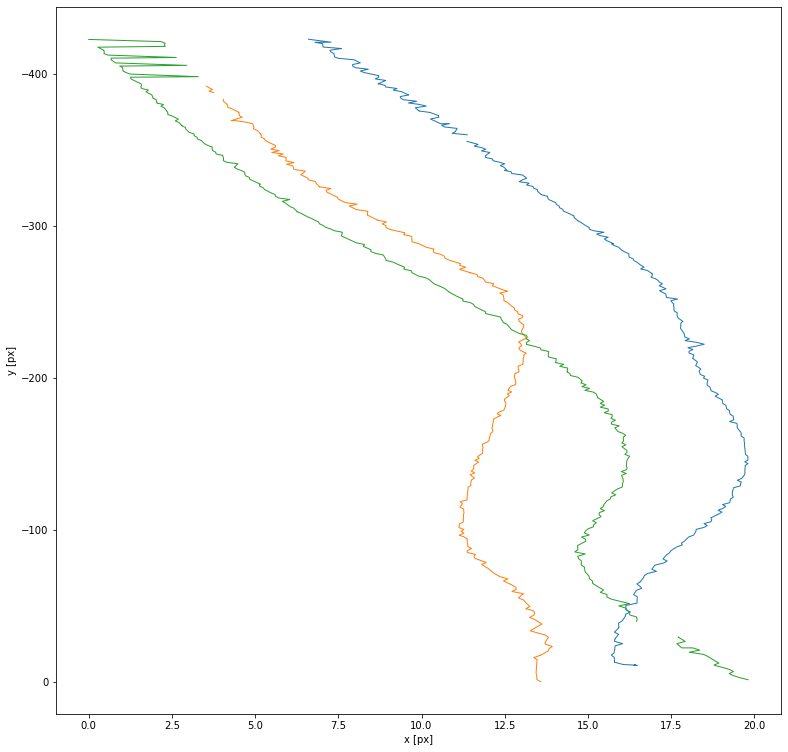

Finished Trajectories
------------------------------------------------


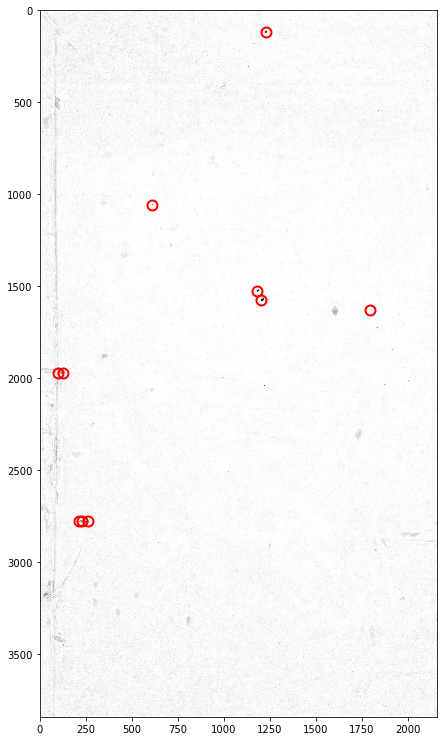

Filtering stubs...
Before: 38
After: 14


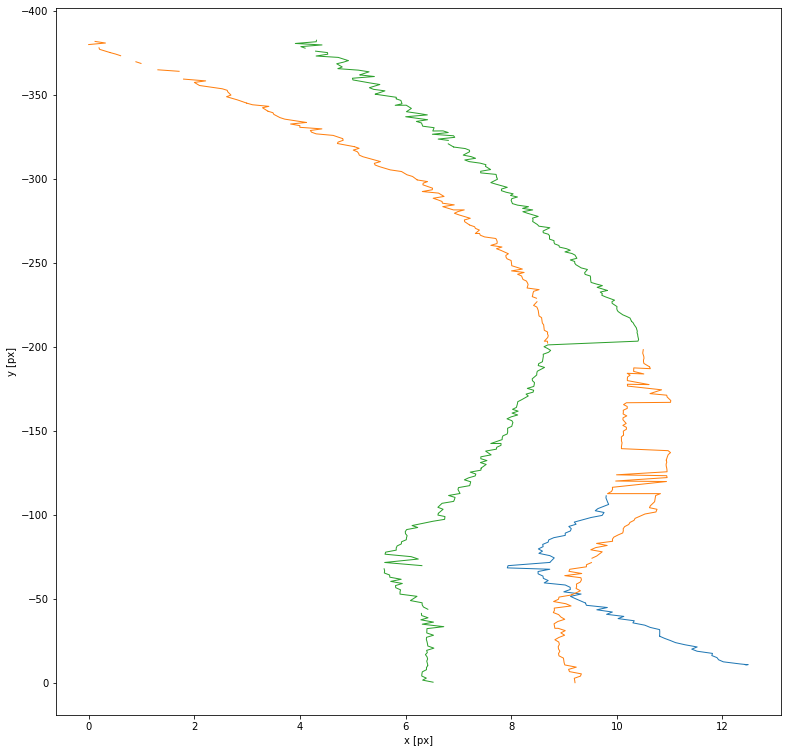

Finished Trajectories
------------------------------------------------


In [8]:
t26 = getTrajectories(v_26,app=app_26,label = "Trial 26")
t28 = getTrajectories(v_28,app=app_28,label = "Trial 28")

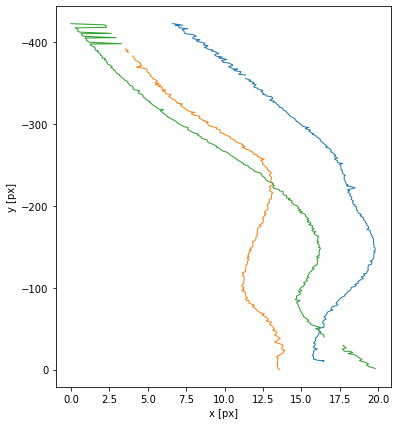

<bound method _AxesBase.yaxis_inverted of <matplotlib.axes._subplots.AxesSubplot object at 0x00000178A3A6EAC0>>


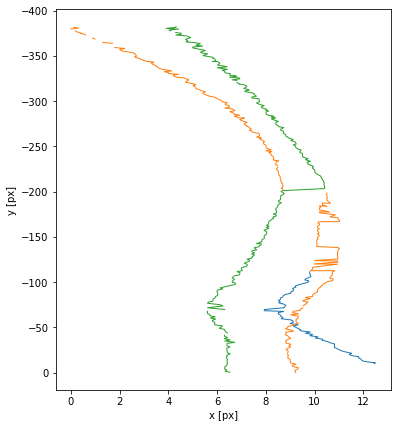

<bound method _AxesBase.yaxis_inverted of <matplotlib.axes._subplots.AxesSubplot object at 0x00000178A3D60580>>


In [12]:
#Pretty up the trajectory plots to be right-side up, have titles etc, and to be the consistent shape I wanted for the poster

def makePlot(t, title = "Title"):
    fig, testa = plt.subplots(figsize=(6,7));
    
    ax = tp.plot_traj(t);
    print(ax.yaxis_inverted)
    ax.invert_yaxis();
    ax.set_title(title, fontsize = 'xx-large');
    ax.set_xlabel("x\n(In units set by the model)");
    ax.set_ylabel("z");
    
    fig.add_subplot(ax)
    fig.savefig(path+"PosterFigures\\" + title +".png");
    plt.close(fig)
    return fig

fig26 = makePlot(t26, title = "Trial 26 Experimental Trajectories")
fig28 = makePlot(t28, title = "Trial 28 Experimental Trajectories")

#these plots are still going to be upside down

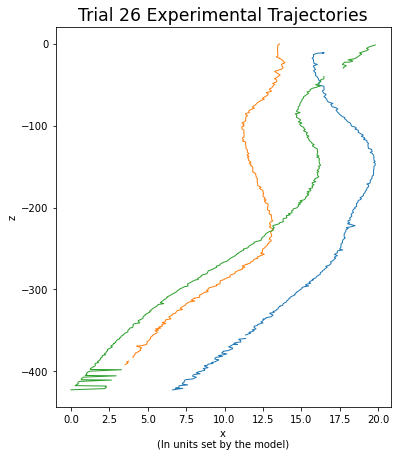

In [13]:
fig26

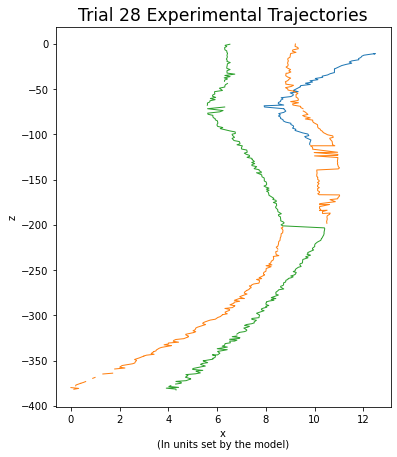

In [14]:
fig28

That's better, so these are worth talking about.

Trial 26 seems mostly in order, there is a weird near-horizontal portion of the blue line near the top, which might indicate some unreliable tracking up there and that the real initial position of the blue particle should be a little more leftwards. The gap in the green trajectory is not too concerning for reasons that will become clear in a minute. We'll move on for now.

Trial 28 looks wonky. The first thing you'll notice is that the blue line abruptly vanishes. This is because past that point the blue and orange particles more or less overlap and trackpy cannot distinguish them, so it kind of goes back and forth centering the particle on whichever one is darker. That's why the midsection of the orange trajectory has all those horizontal jumps. You'll also note that the green and orange trajectories exchange positions halfway down, this is a simple accidental switch of label on trackpy's part.

Trackpy works by going through frame-by-frame and labeling dark spots with a particle number. Then it goes through the frames and the particle numbers that are closest together between frames get labeled as the same particle. Once trackpy does this on all the frames, it can make a complete trajectory for each particle. Sometimes a particle seemingly vanishes for a few frames due it reflecting light just the right way or going out of focus. For this purpose, trackpy has a memory function which allows a particle to vanish for a certain number of frames (in our case 10) and retain its label. This is why the gap in the green trajectory in trial 26 is uninteresting.

For two trajectories to exchange labels like that either they'd have to get close enough to where trackpy swaps their labels by mistake, or, more likely, one of the particles went out of focus at the right time and during those frames the other particles picked up the vanished particle's label. Then when the vanished particle comes back into focus, it picks up the label that the other particle dropeed thanks to the frame memory functionality. Reducing the frame memory here is not a good idea because if I go too much smaller they trajectories loose their continutity and are harder to distinguish from the other dark spots in the vides. I think though, once this is explained, that the plot for trial 28 is quite readable.

# Getting initial conditions to plug into the model, then more plotting

Now that we have these plots, we need to extract the initial positions of the particles from the trajectory data. The trackpy results can simply give us x and z at the first available frame. What we don't have is the y-positions of those particles, i.e. in and out of the plane of the camera. To get this data, I snapped a few stills from the top of the tank as I dropped the particles. Some of these photos came out better than others, but by measuring the distance and angle with respect to the plane of the camer of each of the three particles, we can compute those y-positions.

The images I used for this task: Trial 26 (left), Trial 28 (right). The tank walls are cropped out of these shots, but I used them to measure angles against when performing the analysis. The silver and blue bar at the bottom of each picture runs roughly parallel to the tank's front face, to give you an idea for the orientation of these photos.

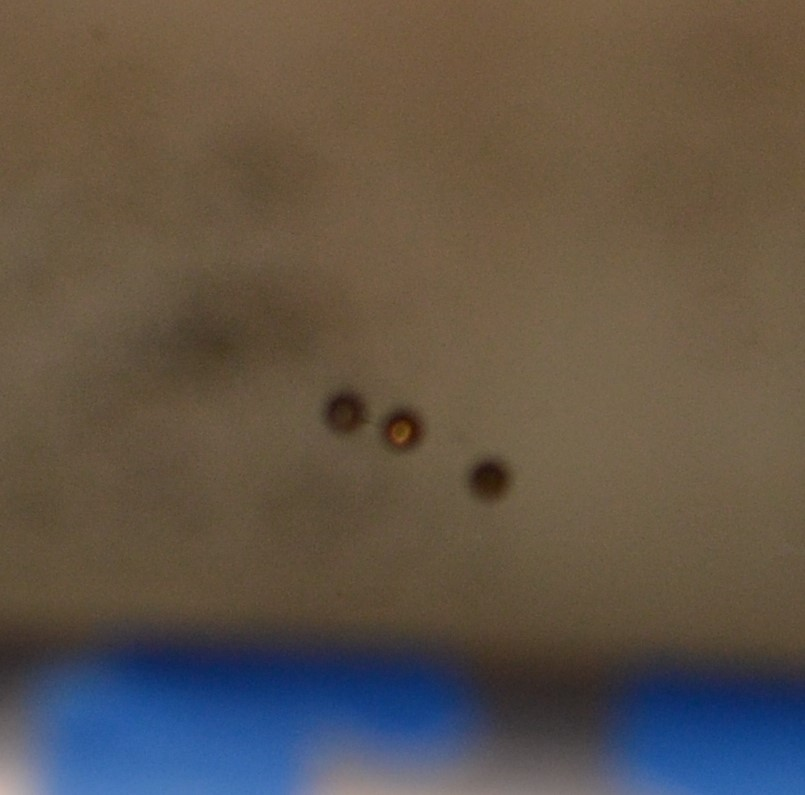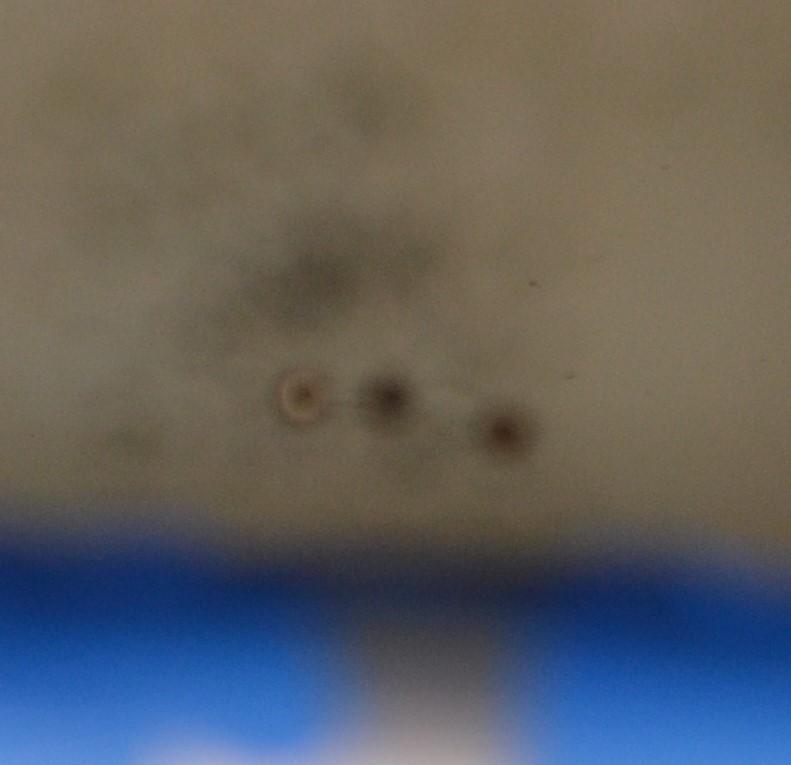

In [16]:
# Getting modeling values from data results

def getInitXY(t):
    #get the particle lables from the trajectories dataframe
    ptcls = np.unique(np.array(t['particle']))
    xs = np.zeros(3)
    zs = np.zeros(3)
    
    #grab the first recorded x and y of each particle
    #'y' in the trajectories dataframe is 'z' in the model
    for i in np.arange(3):
        p = ptcls[i]
        xs[i] = np.array(t[t['particle']==p]['x'])[0]
        zs[i]= np.array(t[t['particle']==p]['y'])[0]
    
    xs = xs
    zs = zs
    
    return xs, zs

xs26, zs26 = getInitXY(t26)
xs28, zs28 = getInitXY(t28)

d_in_simulation = 2*0.762


#get pixels to radii conversion factor with the same method as before
d_in_pixels_26 = np.mean(np.array([33.602,29.486,34.060,28.538,31.821,25.932]))
app_26 = d_in_simulation/d_in_pixels_26

#measure the orientation of the back face of the tank with respect to the vertical in the image
angle_to_vertical_26 = 2.252*np.pi/180

#from the particle closest to the right wall of the tank, measure the center-center distance and the 
ds_26 = np.array([0,101.472,160.295])*app_26
as_26 = np.array([0,29.514,24.851])*np.pi/180

topxs26 = -ds_26*np.cos(as_26-angle_to_vertical_26)+np.max(xs26)
ys26 = -ds_26*np.sin(as_26-angle_to_vertical_26)

ind = np.argsort(-xs26)
match = np.argsort(ind)
ys26 = ys26[match]
topxs26 = topxs26[match]
print("Are the initial y's at the right index?",np.argsort(topxs26)==np.argsort(xs26))

print(np.transpose(np.array([xs26,ys26,zs26])))

#repeat for trial 28
d_in_pixels_28 = np.mean(np.array([50.010,48.703,61.033,47.011,58.078,49.010]))
app_28 = d_in_simulation/d_in_pixels_28
angle_to_vertical_28 = 2.784*np.pi/180

ds_28 = np.array([0,119.570,204.266])*app_28
as_28 = np.array([0,14.370,10.056])*np.pi/180

topxs28 = -ds_28*np.cos(as_28-angle_to_vertical_28)+np.max(xs28)
ys28 = -ds_28*np.sin(as_28-angle_to_vertical_28)

ind = np.argsort(-xs28)
match = np.argsort(ind)
ys28 = ys28[match]
topxs28 = topxs28[match]
print("Are the initial y's at the right index?",np.argsort(topxs28)==np.argsort(xs28))

print(np.transpose(np.array([xs28,ys28,zs28])))

Are the initial y's at the right index? [ True  True  True]
[[ 16.41963252  -2.31693168 -10.65030512]
 [ 13.58327848  -3.0705163   -0.        ]
 [ 19.81245876   0.          -1.26153343]]
Are the initial y's at the right index? [ True  True  True]
[[ 12.44654555   0.         -10.74067605]
 [  9.20792838  -0.69966529  -0.        ]
 [  6.52061533  -0.75332383  -0.29306358]]


Now that we have the initial positions, we simply enter them into an ArrayMovie object from [ShellModel](https://nbviewer.jupyter.org/github/johnemmanuelbond/ShellModel/blob/master/Overview.ipynb), and let it run. In the units of the model, we set the force of gravity to 1. We can also compute this force of gravity by calcuating the mass of the steel ball bearing, times g, minus the buoyant force. This determination, as well as units of mm for distance and of s for time constrain the units of viscosity. It is also important to note that 350 cSt (mm$^2$/s) is kinematic viscosity, and the model accepts a dynamic viscosity. They are related by the density of the silicone oil: ~970kg/m$^3$. Once you do the dimensional analysis problem you arrive at visc for the viscosity we should use in the model.

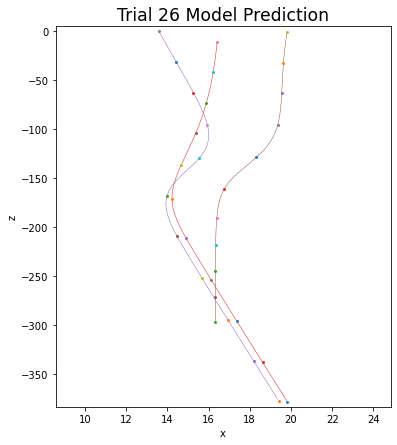

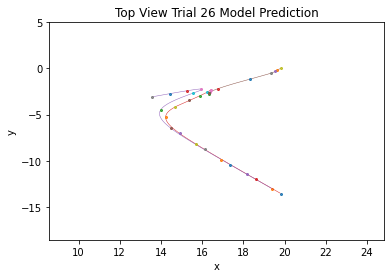

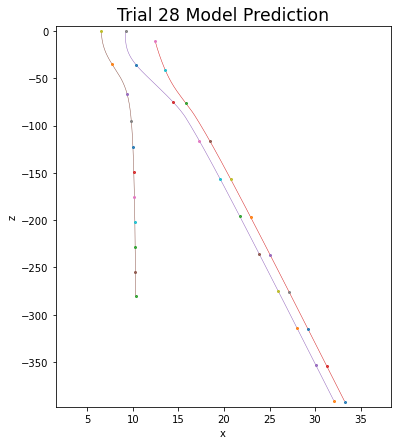

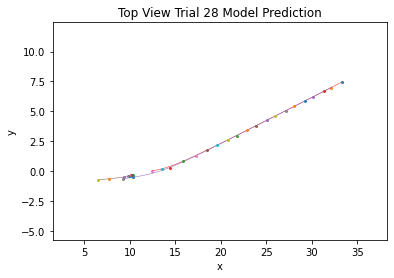

In [18]:
#Run Resultant Simulations

visc = 0.339/4.21 #350cSt
r = 0.762 #ball radius

def SimulateData(xs, ys, zs, title):
    ps = np.transpose(np.array([xs,ys,zs]))
    
    #one hard sphere
    pt = Collection(np.array([[0,0,0]]),a=r)
    
    #set up the initial particles at their initial conditions under a constant force
    pArr = ParticleArray(ps, pt, visc*np.array([[1,0,0],[0,1,0],[0,0,1]]), np.array([0,0,-1]))
    
    movie = ArrayMovie(pArr, 300, 1, isIso=True)
    movie.simulate(considerClumping=True)
    
    # plotting
    fig, ax = plt.subplots(figsize = (6,7))
    movie.updateAxes(movie.s-1,ax)
    frames = np.linspace(0,movie.s,10,endpoint=False).astype(int)
    for i in frames:
        movie.plotInstance(i, ax)
    
    #More plotting formatting
    ax.set_title(title, fontsize = 'xx-large')
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    fig.savefig(path+"PosterFigures\\" + title +".png")
    
    #do basically the same thing but look from the top down, it is an interesting thing to look at.
    pArr = ParticleArray(ps, pt, visc*np.array([[1,0,0],[0,1,0],[0,0,1]]), np.array([0,0,-1]))
    movie = ArrayMovie(pArr, 300, 1, isIso=True,axis='z', title = "Top View "+title)
    movie.simulate(considerClumping=True)
    fig = movie.getStill()
    fig.savefig(path+"PosterFigures\\Top View " + title +".png")
    
SimulateData(xs26,ys26,zs26, title = "Trial 26 Model Prediction")
SimulateData(xs28,ys28,zs28, title = "Trial 28 Model Prediction")

# Initial Takeaways

Clearly the model does not specifically predict the results of the experiment. This is not too surprising. First of all, the model predicts that the character of the oscillatory modes (things like the length of each oscillation, which spheres exchange places, how many periods occur per unit length)is sensitive to changes in the initial position of order 0.05 radii (see below cell). Since the model is so sensitive, any large uncertainty in the initial positions we extract from the data is enough to throw the model off, and we have plenty of reasons to expect uncertainty from the experimental position data:

a) it's unlikely that the photograph was shot at the same instant as trackpy first picks up the particles.

b) the still images had significant blur, the distance measurements I used to determine the initial y-postions have more uncertainty than the sensitivity of the model.

c) likewise, trackpy centers it's position algorithm on the darkest part of the particle. This 'darkest' part can change as the particle sediments, interacts with shadows/camera flashes. Realistically, all the x-y data from trackpy cannot have sub-diameter precision, which is not enough precision to expect the model to exactly replicate the results.

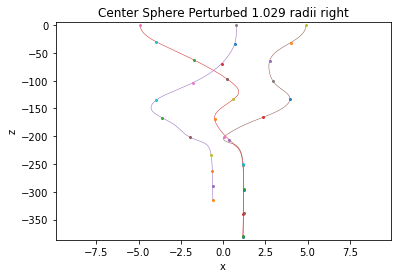

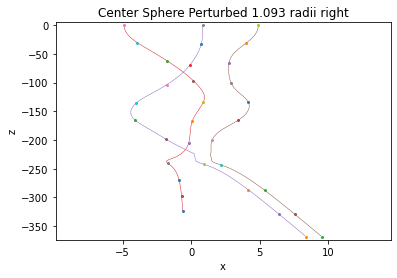

In [49]:
#one hard sphere
pt = Collection(np.array([[0,0,0]]),a=r)

visc = 0.339/4.21 #350cSt
r = 0.762 #ball radius

#two oscillatory modes
d=4.9
for p in np.array([0.16,0.17]):
    ps = np.array([[-d,0,0],[p*d,0,0],[d,0,0]])
    pArr = ParticleArray(ps, pt, visc*np.array([[1,0,0],[0,1,0],[0,0,1]]), np.array([0,0,-1]))

    movie = ArrayMovie(pArr, 300, 1, isIso=True, title = "Center Sphere Perturbed " + str(np.round(d*p/r, 3)) + " radii right")
    movie.simulate(considerClumping=True)

    movie.getStill()